# Creating an optimal Molecule's Potential Energy Curve using Adapt-VQE

A potential energy curve gives the ground energy of an assemble of atoms as function of the distances between them. The global minima of the curve indicates the binding energy and internuclear distance for the stable molecule. Therefor, such curve can be powerful tool in computational chemistry, for predicting molecular structure and spectrum.

In this tutorial, we will demonstrate how, using Classiq's VQE package, the user can create a Molecule's potential energy curve, and compare the result those of the Hartree-Fock approximative method and to the exact results. The exact solution is a result of diagonalizing the Hamiltonian.

## Main Idea
The main idea is to use the __qpe_for_molecules.ipynb__ notebook, but replace __qpe_flexible__ with __my_qpe_flexible__. Then, create an iterator function that uses this approach to find eigenvalues as part of an adapt-VQE implementation.

In [31]:
#import time
import matplotlib.pyplot as plt
import numpy as np
import itertools
from classiq import *
from classiq.applications.chemistry import ChemistryExecutionParameters,HEAParameters,Molecule,MoleculeProblem,UCCParameters
from classiq.execution import OptimizerType
from classiq.applications.combinatorial_helpers.pauli_helpers.pauli_utils import pauli_operator_to_hamiltonian
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi
#authenticate(overwrite=True)


## 0. Define Molecules
We start this defining some examples of molecular pairs and triplets.

In [32]:
num1, start1, stop1 = 3, 0.20, 1   #First Linear Space 
num2, start2, stop2 = 3, 1.4, 3.5  #Second Linear Space
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2)) # prepare x,y vectors
molecules_LiH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, x))]) for x in distance]
molecules_FH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("F", (0.0, 0.0, x))]) for x in distance]
molecules_H2 = [Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, x))]) for x in distance]
molecules_O2 = [Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, x))]) for x in distance]
molecules_H2O = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y) in itertools.product(distance,distance)]
molecules_H3 = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
molecules_O3 = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("O", (0, x, y)), ("O", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
molecules_BeH2 = [Molecule(atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, x)), ("H", (0, 0, -x))]) for x in distance]

## 1. Vanilla VQE
This part would imitate the model of VQE already implemented on Classiq

In [33]:
VQE_energy, HF_energy, exact_energy = [],[],[]
qmods, qprogs, results, durations = [],[],[],[]
for k in range(len(distance)):
    molecule = molecules_H2[k]
    chemistry_problem = MoleculeProblem(molecule=molecule,mapping="bravyi_kitaev",z2_symmetries=True,freeze_core=True)  # jordan_wigner or bravyi_kitaev
    qmod = construct_chemistry_model(
        chemistry_problem=chemistry_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=50,initial_point=None))
    qmods.append(qmod)
    qprog = synthesize(qmod);qprogs.append(qprog)
    result = execute(qprog).result();results.append(result)
    chemistry_result_dict = result[1].value
    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    VQE_energy.append(chemistry_result_dict["total_energy"])
    HF_energy.append(chemistry_result_dict["hartree_fock_energy"])
    exact_energy.append(result_exact)

This graph presents the ground state for $H_{2}$ molecule as a function of the distance between the two hydrogen atoms. One can see that both the HF solution and Classiq VQE present decent results around the global minima. For further distances, Classiq VQE stays close to the exact solution while the HF solution gradually deviates. The source of this lack of correspondence is with the lack of flexible correlations within the HF model, which is enabled within VQE scope.
One can similarly create graphs for different molecules (even n- dimensional or larger atom assemblies), to explore more curves.


# 2. Define Adapt_VQE using Flexible QPE

In [34]:
#Flexible QPE
@qfunc
def my_qpe_flexible(unitary: QCallable[CInt, QArray[QBit]],state: QArray[QBit],phase: QArray[QBit]) -> None:
    apply_to_all(H, phase)
    repeat(count=phase.len,iteration=lambda index: control(ctrl=phase[index],stmt_block=lambda: unitary(2**index, state)))
    invert(lambda: qft(phase),)

aVQE_energy=[]
for k in range(len(distance)):
    molecule = molecules_H2[k]
    gs_problem = MoleculeProblem(molecule=molecule,basis="sto3g",mapping="bravyi_kitaev",z2_symmetries=True,freeze_core=True) # jordan_wigner or bravyi_kitaev
    print(gs_problem)
    
    operator = gs_problem.generate_hamiltonian()
    gs_problem = gs_problem.update_problem(operator.num_qubits)
    mol_hamiltonian = pauli_operator_to_hamiltonian(operator.pauli_list)
    #problem_size = len(mol_hamiltonian[0].pauli)
    #print(f"The Hamiltonian is defined on {problem_size} qubits, and contains {len(mol_hamiltonian)} Pauli strings")
    mat = hamiltonian_to_matrix(mol_hamiltonian)
    w, v = np.linalg.eig(mat)
    classical_sol = np.real(min(w))
    coeiffs = [term.coefficient for term in mol_hamiltonian]
    def trim_hamiltonian(hamiltonian, threshold):
        return [PauliTerm(pauli=term.pauli, coefficient=term.coefficient) for term in hamiltonian if np.abs(term.coefficient) > threshold]
    THRESHOLD = 0.03
    trimmed_mol_hamiltonian = trim_hamiltonian(mol_hamiltonian, THRESHOLD)
    def normalize_hamiltonian(hamiltonian):
        approx_lambda_max = sum(np.abs(term.coefficient) for term in hamiltonian)
        normalization = 2 * approx_lambda_max
        normalized_mol_hamiltonian = [PauliTerm(pauli=term.pauli, coefficient=term.coefficient / (normalization)) for term in hamiltonian]
        return normalization, normalized_mol_hamiltonian
    normalization, normalized_mol_hamiltonian = normalize_hamiltonian(trimmed_mol_hamiltonian)  #¿Cómo traspasar este hamiltoniano al comando que continúa el VQE?
 
    qmod = construct_chemistry_model(
        chemistry_problem=gs_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=50,initial_point=None))
    preferences = Preferences(optimization_level=3)
    qmods.append(qmod)
    qprog = synthesize(qmod, preferences=preferences);qprogs.append(qprog)
    result = execute(qprog).result();results.append(result)
    chemistry_result_dict = result[1].value
    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    aVQE_energy.append(chemistry_result_dict["total_energy"])


kind='molecule' mapping=<FermionMapping.BRAVYI_KITAEV: 'bravyi_kitaev'> z2_symmetries=True num_qubits=None molecule=Molecule(atoms=[Atom(symbol='H', x=0.0, y=0.0, z=0.0), Atom(symbol='H', x=0.0, y=0.0, z=0.2)], spin=1, charge=0) basis='sto3g' freeze_core=True remove_orbitals=[]
kind='molecule' mapping=<FermionMapping.BRAVYI_KITAEV: 'bravyi_kitaev'> z2_symmetries=True num_qubits=None molecule=Molecule(atoms=[Atom(symbol='H', x=0.0, y=0.0, z=0.0), Atom(symbol='H', x=0.0, y=0.0, z=0.6000000000000001)], spin=1, charge=0) basis='sto3g' freeze_core=True remove_orbitals=[]
kind='molecule' mapping=<FermionMapping.BRAVYI_KITAEV: 'bravyi_kitaev'> z2_symmetries=True num_qubits=None molecule=Molecule(atoms=[Atom(symbol='H', x=0.0, y=0.0, z=0.0), Atom(symbol='H', x=0.0, y=0.0, z=1.0)], spin=1, charge=0) basis='sto3g' freeze_core=True remove_orbitals=[]
kind='molecule' mapping=<FermionMapping.BRAVYI_KITAEV: 'bravyi_kitaev'> z2_symmetries=True num_qubits=None molecule=Molecule(atoms=[Atom(symbol='H',

## 3. Plot and comparing results

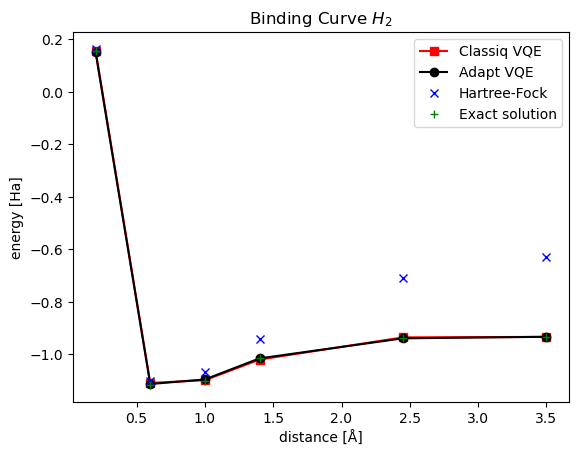

In [35]:
plt.plot(distance, VQE_energy, "r-s", distance, aVQE_energy, "k-o", distance, HF_energy, "bx", distance, exact_energy, "g+")
plt.xlabel(r"distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Adapt VQE", "Hartree-Fock", "Exact solution"])
plt.title(r"Binding Curve $H_{2}$")
plt.show()
write_qmod(qmods[-1], "adapt_vqe_energy_curve") # save the last model to a qmod file

In [36]:
#m1=min(VQE_energy); print(m1)
#m2=min(aVQE_energy); print(m2)
#m3=min(HF_energy); print(m3)
#m4=min(exact_energy); print(m4)
#print('----')
#print(100*np.abs(m1-m4)/m4)
#print(100*np.abs(m2-m4)/m4)
#print(100*np.abs(m3-m4)/m4)

In [37]:
#import qutip as qt
#from qiskit_nature.second_q.drivers import PySCFDriver
#from qiskit_nature.second_q.operators import FermionicOp
#from qiskit_nature.second_q.mappers import JordanWignerMapper
#from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer
#def SX(N, k):
#    """Create a sigma_X operator at position k from
#    a Hilbert space of N qubits
#    """
#    L = [qt.qeye(2)]*N
#    L[k] = qt.sigmax()
#    return qt.tensor(L)

#def SY(N, k):
#    """Create a sigma_Y operator at position k from
#    a Hilbert space of N qubits
#    """
#    L = [qt.qeye(2)]*N
#    L[k] = qt.sigmay()
#    return qt.tensor(L)

#def SZ(N, k):
#    """Create a sigma_Z operator at position k from
#    a Hilbert space of N qubits
#    """
#    L = [qt.qeye(2)]*N
#    L[k] = qt.sigmaz()
#    return qt.tensor(L)


#from qutip import create, destroy

#def Sm(N, k):
#    """Create a sigma_X operator at position k from
#    a Hilbert space of N qubits
#    """
#    L = [qt.qeye(2)]*N
#    L[k] = destroy(2)
#    return qt.tensor(L)

#def Sp(N, k):
#    """Create a sigma_X operator at position k from
#    a Hilbert space of N qubits
#    """
#    L = [qt.qeye(2)]*N
#    L[k] = create(2)
#    return qt.tensor(L)


In [38]:
## "CLASES"
#N = 4
#s0 = qt.basis(2, 0)
#s1 = qt.basis(2, 1)
#ESTADOS DE CADA CLASE DE ENTRELAZAMIENTO
#psi_C1 = qt.tensor(s0,s0,s0,s0)
#psi_C3 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+ qt.tensor(s1,s0,s1,s0))
#psi_C9 = 1/2*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s1,s0) + qt.tensor(s1,s1,s1,s1) )
# psi_C11 = 1/np.sqrt(3)*(qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s0))
#psi_C11=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
#psi_C15 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+ qt.tensor(s1,s1,s1,s0))
#psi_C19 = 1/2*(qt.tensor(s1,s0,s0,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s0,s1,s0)+ qt.tensor(s0,s0,s0,s1))
#psi_C19=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
#psi_C22=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s1,s1,s0)).unit()
#psi_C26 = 1/np.sqrt(2)*(qt.tensor(s0,s0,s0,s0)+qt.tensor(s1,s1,s1,s1))
#psi_C28 = (1 / np.sqrt(5)) * (qt.tensor(s0, s0, s0, s0) +    qt.tensor(s0, s0, s1, s1) +    qt.tensor(s0, s1, s1, s0) +    qt.tensor(s1, s0, s0, s1) +    qt.tensor(s1, s1, s0, s0)) #REVISAR
#psi_C31 = (1 / np.sqrt(12)) * (qt.tensor(s0, s0, s0, s0)- qt.tensor(s0, s0, s0, s1) - qt.tensor(s0, s0, s1, s0)    - qt.tensor(s0, s1, s0, s0)    + qt.tensor(s0, s1, s0, s1)    + qt.tensor(s0, s1, s1, s1)    - qt.tensor(s1, s0, s0, s0)    + qt.tensor(s1, s0, s1, s0)    + qt.tensor(s1, s0, s1, s1)   + qt.tensor(s1, s1, s0, s1)    + qt.tensor(s1, s1, s1, s0)    + qt.tensor(s1, s1, s1, s1))
#c = 2
#psi_C33 = (qt.tensor(s0, s0, s0, s0)+ c * qt.tensor(s0, s0, s1, s1)- (1 + c) * qt.tensor(s0, s1, s0, s1)- (1 + c) * qt.tensor(s1, s0, s1, s0)+ c * qt.tensor(s1, s1, s0, s0)+ qt.tensor(s1, s1, s1, s1)).unit()
#psi_C36 = (qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s0,s1)).unit()
#psi_C39 = (qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s1,s0)).unit()
#psi_C43=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s1,s0)).unit()
#psi_C48=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s1)).unit()
#psi_C50=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
#psi_C57=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
#psi_C60=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s1,s1)).unit()
#psi_C62=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s0,s0)).unit()
#psi_C65=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s0,s1,s1,s0)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s1)+qt.tensor(s1,s1,s1,s0)+qt.tensor(s1,s1,s1,s1)).unit()
#psi_C67=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s0,s1)+qt.tensor(s0,s0,s1,s0)-qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s1,s0,s1)-qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)+qt.tensor(s1,s1,s1,s1)).unit()
#psi_C68=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s1,s1,s1)).unit()
#psi_C72=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s1,s1,s1)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s0,s0)).unit()
#psi_C75=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s1,s0,s0,s1)+qt.tensor(s1,s1,s1,s0)).unit() #REVISAR
#psi_C80=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s1)+qt.tensor(s1,s1,s1,s0)).unit()
#psi_C82=(qt.tensor(s0,s0,s0,s0)+qt.tensor(s0,s0,s1,s1)+qt.tensor(s0,s1,s0,s0)+qt.tensor(s0,s1,s0,s1)+qt.tensor(s1,s0,s0,s0)+qt.tensor(s1,s0,s1,s0)+qt.tensor(s1,s1,s1,s1)).unit() #REVISAR


In [39]:
## Hamiltonianos
#def H_Heisemberg(n, arg, arg2):
#    H = 0 #Creamos el Hamiltoniano, con un offset en la energía

#    g = 1
#    J = arg2

#    for i in range(n):
#            if i != n-1:
#               H = H + g*SZ(n,i)+ J*(SX(n,i)*SX(n,i+1)+SY(n,i)*SY(n,i+1))+arg*SZ(n,i)*SZ(n,i+1) # Sumamos los términos g_ij sigmaz_i sigmaz_j
#            else:
#                H = H + g*SZ(n,i) + J*(SX(n,i)*SX(n,0)+SY(n,i)*SY(n,0))+arg*SZ(n,i)*SZ(n,0)
                #H = H + g*Sig(n,i,Sz)
#    return H


#def H2_Hamiltonian_Operator(r_i):
#    """
#    This function returns the Hamiltonian operator of the H2
#    molecule at a given distance r_i.

#    args:
#        r_i: distance between the two hydrogen atoms
#    """

#    driver = PySCFDriver(
#        atom= f'H .0 .0 .0; H .0 .0 {r_i}',
#        unit = DistanceUnit.ANGSTROM,
#        basis= 'sto-3g',
#    )

#    problem = driver.run()
#    second_q_ham = problem.hamiltonian.second_q_op()
#    num_spin_orbitals = problem.num_spatial_orbitals
#    identity_op = FermionicOp.one()

    # Escalar el operador identidad por la energía nuclear
#    nuclear_energy_op = problem.nuclear_repulsion_energy * identity_op
#    hamiltonian_without_nuclear = second_q_ham + nuclear_energy_op

#    mapper = JordanWignerMapper()

#    pauli_hamiltonian_op = mapper.map(hamiltonian_without_nuclear)
#    matrix_representation = pauli_hamiltonian_op.to_matrix()
#    qt_hamiltonian_op = qt.Qobj(matrix_representation, dims=[[2,2,2,2], [2,2,2,2]])

#    return qt_hamiltonian_op

#def LiH_Hamiltonian_Operator(r_i):
#    """
#    This function returns the Hamiltonian operator of the H2
#    molecule at a given distance r_i.

#    args:
#        r_i: distance between the two hydrogen atoms
#    """

#    driver = PySCFDriver(atom=f"Li 0 0 0; H 0 0 {r_i}", basis="sto-3g")
#problem = driver.run()

#    full_problem = driver.run()

#    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

#    problem = act_space_tf.transform(full_problem)
#    hamiltonian = problem.hamiltonian.second_q_op()
#    num_spin_orbitals = problem.num_spatial_orbitals
#    identity_op = FermionicOp.one()

# Escalar el operador identidad por la energía nuclear
#    nuclear_energy_op = problem.nuclear_repulsion_energy * identity_op
#    AST_energy_op = problem.hamiltonian.constants['ActiveSpaceTransformer']*identity_op
#    hamiltonian_without_nuclear = hamiltonian + nuclear_energy_op + AST_energy_op

#    mapper = JordanWignerMapper()

#    pauli_hamiltonian_op = mapper.map(hamiltonian_without_nuclear)
#    matrix_representation = pauli_hamiltonian_op.to_matrix()
#    qt_hamiltonian_op = qt.Qobj(matrix_representation, dims=[[2,2,2,2], [2,2,2,2]])

#    return qt_hamiltonian_op

#def HF_Hamiltonian_Operator(r_i):
#    """
#    This function returns the Hamiltonian operator of the H2
#    molecule at a given distance r_i.

#    args:
#        r_i: distance between the two hydrogen atoms
#    """

#    driver = PySCFDriver(atom=f"F 0 0 0; H 0 0 {r_i}", basis="sto-3g")

#    full_problem = driver.run()

#    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

#    problem = act_space_tf.transform(full_problem)
#    hamiltonian = problem.hamiltonian.second_q_op()
#    num_spin_orbitals = problem.num_spatial_orbitals
#    identity_op = FermionicOp.one()

# Escalar el operador identidad por la energía nuclear
#    nuclear_energy_op = problem.nuclear_repulsion_energy * identity_op
#    AST_energy_op = problem.hamiltonian.constants['ActiveSpaceTransformer']*identity_op
#    hamiltonian_without_nuclear = hamiltonian + nuclear_energy_op + AST_energy_op

#    mapper = JordanWignerMapper()

#    pauli_hamiltonian_op = mapper.map(hamiltonian_without_nuclear)
#    matrix_representation = pauli_hamiltonian_op.to_matrix()
#    qt_hamiltonian_op = qt.Qobj(matrix_representation, dims=[[2,2,2,2], [2,2,2,2]])

#    return qt_hamiltonian_op



#def concurrence(rho):
#    sy = qt.sigmay()
#    rho_star = rho.conj()
#    R = rho * (qt.tensor(sy, sy)) * rho_star * (qt.tensor(sy, sy))
#    eigenvalues = R.eigenenergies()
    #eigenvalues = np.sqrt(R.eigenenergies())
#    eigenvalues.sort()  # for increase order
#    eigenvalues = np.abs(eigenvalues)
    #max_eigenvalue = eigenvalues[-1] - eigenvalues[-2] - eigenvalues[-3] - eigenvalues[-4]
#    max_eigenvalue = np.sqrt(eigenvalues[-1]) - np.sqrt(eigenvalues[-2]) - np.sqrt(eigenvalues[-3]) - np.sqrt(eigenvalues[-4])
#    return max(0, max_eigenvalue)

In [40]:
#import numpy as np
#from scipy.optimize import minimize
# Número de qubits
#N = 4
#pool = []
#pool_labels = []

# ----- 1. Operadores LOCALES -----
#for i in range(N):
#    for pauli, label_char, func in [('X', 'X', SX), ('Y', 'Y', SY), ('Z', 'Z', SZ)]:
#        op = func(N, i)
#        label = ['_'] * N
#        label[i] = label_char
#        pool.append(op)
#        pool_labels.append(''.join(label))

# ----- 2. Operadores BILOCALes -----
# Todas las combinaciones de 2 qubits
#for qubits in itertools.combinations(range(N), 2):
    # Combinaciones de 2 operadores entre X, Y, Z
#    for paulis in itertools.product(['X', 'Y', 'Z'], repeat=2):
#        label = ['_'] * N
#        op = qt.tensor([qt.qeye(2)] * N)
#        for idx, qubit in enumerate(qubits):
#            if paulis[idx] == 'X':
#                op = op * SX(N, qubit)
#                label[qubit] = 'X'
#            elif paulis[idx] == 'Y':
#                op = op * SY(N, qubit)
#                label[qubit] = 'Y'
#            else:
#                op = op * SZ(N, qubit)
#                label[qubit] = 'Z'
#        pool.append(op)
#        pool_labels.append(''.join(label))


# INITIAL ANSATZ
#psi_0 = psi_C43


# HAMILTONIAN   
#Hf = HF_Hamiltonian_Operator(2)

# Gradient threshold
#epsilon = 1e-3

# Ansatz builder
#def build_ansatz(params, operators, initial_state):
#    state = initial_state
#    for theta, op in zip(params, operators):
#        state = (1j * theta * op).expm() * state
#    return state

# Cost function
#def cost_function(params, operators, initial_state, Hf):
#    psi = build_ansatz(params, operators, initial_state)
#    return qt.expect(Hf, psi).real

# ADAPT-VQE loop
#ansatz_ops = []
#params = []
#energy_trace = []
#grad_trace = []
#ansatz_labels = []
#constraints = []


#while True:
#    psi = build_ansatz(params, ansatz_ops, psi_0) if params else psi_0
#    gradients = []

#    for A in pool:
#        comm = Hf * A - A * Hf
#        grad = ((psi.dag() * comm * psi))  # No factor 2, no imag
#        gradients.append(abs(grad))

#    max_grad = max(gradients)
#    grad_trace.append(max_grad)

#    if max_grad < epsilon:
#        break

#    max_index = np.argmax(gradients)

#    ansatz_ops.append(pool[max_index])
#    ansatz_labels.append(pool_labels[max_index])
#    init_theta = params + [0.01]
#    constraints = []
#    for i in range(len(init_theta)):
#        constraints.append({'type': 'ineq', 'fun': lambda x, i=i: x[i]})                  # x[i] ≥ 0
#        constraints.append({'type': 'ineq', 'fun': lambda x, i=i: 2 * np.pi - x[i]}) 

#    result = minimize(
#        cost_function,
#        init_theta,
#        args=(ansatz_ops, psi_0, Hf),
#        method='COBYLA',
#        options={'disp': False, 'maxiter': 1000}
#    )

#    params = list(result.x)
#    energy_trace.append(result.fun)

#result = minimize(
#        cost_function,
#        init_theta,
#        args=(ansatz_ops, psi_0, Hf),
#        method='COBYLA',
#        options={'disp': False, 'maxiter': 1000}
#    )

#energy_trace.append(result.fun)
#print(f"Número total de operadores en el ansatz: {len(ansatz_ops)}")
#print(f"Energía final: {energy_trace[-1]}")
#print(f"Gradientes máximos por iteración: {grad_trace}")

In [41]:
#import pathlib
#from openfermion.chem import MolecularData
#path = (
#    pathlib.Path(__file__).parent.resolve()
#    if "__file__" in locals()
#    else pathlib.Path(".")
#)
#geometry_file = path / "lih.xyz"

# Set up molecule parameters
#basis = "sto-3g"  # Basis set
#multiplicity = 1  # Singlet state S=0
#charge = 0  # Neutral molecule

# geometry
#with open(geometry_file, "r") as f:
#    lines = f.readlines()
#    atom_lines = lines[2:]  # skip atom count and comment
#    geometry = []
#    for line in atom_lines:
#        parts = line.strip().split()
#        symbol = parts[0]
#        coords = tuple(float(x) for x in parts[1:4])
#        geometry.append((symbol, coords))

#print(geometry)
#description = "LiH"

# Create MolecularData object
#molecule = MolecularData(geometry, basis, multiplicity, charge, description)

In [42]:
#from openfermionpyscf import run_pyscf

#RECALCULATE_MOLECULE = True  # can be set to False after initial run
#if RECALCULATE_MOLECULE:
#    molecule = run_pyscf(
#        molecule,
#        run_mp2=True,
#        run_cisd=True,
#        run_ccsd=True,
#        run_fci=True,  # relevant for small, classically solvable problems
#    )
#    molecule.save()

#molecule.load()

#n_spatial_orbitals = molecule.n_orbitals
#n_electrons = molecule.n_electrons
#print(
#    f"The electronic structure problems has {2*n_spatial_orbitals} spin orbitals, and we need to occupy {n_electrons} electrons"
#)